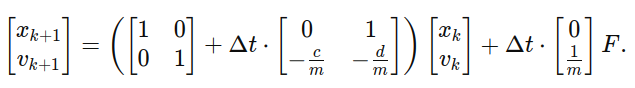

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import pygame
import ctypes

class MassSpringDamperEnv(gym.Env):
    def __init__(self, m=0.1, c=1.0, d=0.1, delta_t=0.01, nlin = False):
        super(MassSpringDamperEnv, self).__init__()

        # Physical parameters
        self.nonlinear = nlin
        self.m = m
        self.c = c
        self.d = d
        self.delta_t = delta_t  # Time step for discretization
        self.input_limit = 10.0

        # State: [position, velocity]
        self.state = np.array([0.0, 0.0])

        # Action space: Force input with constraints
        self.action_space = spaces.Box(low=-self.input_limit, high=self.input_limit, shape=(1,), dtype=np.float32)

        # Observation space: [position, velocity]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(2,), dtype=np.float32)

        # Initialize pygame for rendering
        self.screen = None
        self.width, self.height = 600, 200
        self.mass_pos = self.width // 2  # Initial mass position in the middle
        self.spring_origin = self.mass_pos - 200  # Fixed point for spring start
    def reset(self):
        # Reset state to initial conditions
        self.state = np.array([0.0, 0.0])  # Start at rest
        return self.state

    def step(self, action):
        # Unpack state
        x, v = self.state

        # Apply force (action)
        F = action

        # Non-linear stiffness
        if self.nonlinear == True:
            c = np.tanh(x)
        else:
            c = self.c
        # Continious system dynamics
        A = np.array([[0, 1], [-c / self.m, -self.d / self.m]])
        B = np.array([0, 1 / self.m])

        # Calculate the next state
        self.state = (np.eye(2) + self.delta_t * A) @ self.state + self.delta_t * B * F

        # Calculate reward (deviation from origin)
        reward = -np.sum(np.square(self.state))

        done = False # maybe when x exceeds some bounds

        return self.state, reward, done, {}

    def render(self, mode="human"):
        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((self.width, self.height))
            pygame.display.set_caption("Mass-Spring-Damper System")
            # Set window to be always on top
            hwnd = pygame.display.get_wm_info()['window']
            ctypes.windll.user32.SetWindowPos(hwnd, -1, 0, 0, 0, 0, 0x0001)

        self.screen.fill((255, 255, 255))

        # Parameters for visualization
        x = self.state[0]
        mass_x = int(self.mass_pos + x * 25)  # Scale position for visualization

        pygame.draw.line(self.screen, (0, 0, 0), (self.spring_origin, self.height // 2 - 20), (self.spring_origin, self.height // 2 + 20), 4)

        # Draw spring as a line
        pygame.draw.line(self.screen, (0, 0, 0), (self.spring_origin, self.height // 2), (mass_x, self.height // 2), 2)

        # Draw mass as a rectangle
        mass_rect = pygame.Rect(mass_x - 10, self.height // 2 - 10, 20, 20)
        pygame.draw.rect(self.screen, (0, 255, 0), mass_rect)

        pygame.display.flip()

    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None


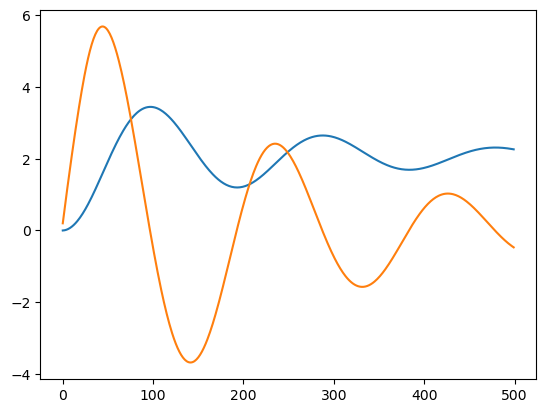

In [ ]:
# Example Nonlinear
if __name__ == "__main__":
    env = MassSpringDamperEnv(nlin=True)
    obs = env.reset()
    save = []
    clock = pygame.time.Clock()
    for _ in range(500):  # Run 10 steps
        action = np.array(2)  # Example action (constant force of 0.1)
        obs,reward, done, _ = env.step(action)
        save.append(obs)
        env.render()
        clock.tick(400)

env.close()
plt.plot(save)
plt.show()

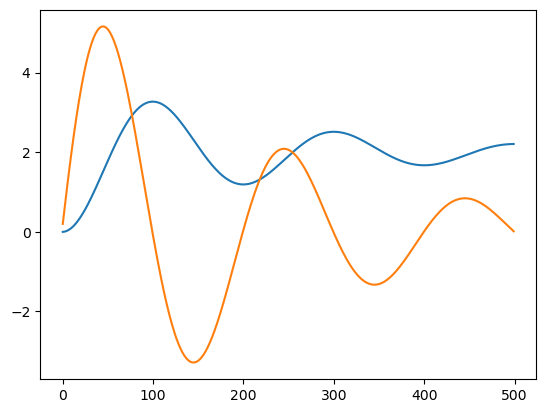

In [ ]:
# Example Linear
if __name__ == "__main__":
    env = MassSpringDamperEnv()
    obs = env.reset()
    save = []
    clock = pygame.time.Clock()
    for _ in range(500):  # Run 10 steps
        action = np.array(2)  # Example action (constant force of 0.1)
        obs,reward, done, _ = env.step(action)
        save.append(obs)
        env.render()
        clock.tick(400)

env.close()
plt.plot(save)
plt.show()